In [2]:
from transformers import AutoModel
import adapters
import torch
from adapters import BnConfig, LoRAConfig

In [3]:
path1='model_weight/Bert_adp_bottleneck_domain_False_quality_True_loss_type_qldl_batch_64_fold4'
path2='model_weight/Bert_adp_bottleneck_domain_True_quality_False_loss_type_qldl_batch_64_fold4'

In [4]:
weighted1= torch.load(path1)
weighted2= torch.load(path2)

In [41]:
class Quality_Model(torch.nn.Module):
    def __init__(self,config, weighted, adapter_type='None'):
        super(Quality_Model, self).__init__()
        
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        #self.dropout = nn.Dropout(p=bert_model_config.hidden_dropout_prob)
        if adapter_type== 'bottleneck':
            adapters.init(self.bert)
            self.bert.add_adapter("bottleneck_adapter", config=config)
            self.bert.train_adapter("bottleneck_adapter")                
        else:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.fcs_cc = torch.nn.Linear(768 , 768)
        self.fcs_c = torch.nn.Linear(768 , 768)

        self.drop=torch.nn.Dropout(0.2)       
        self.load_module_weight(weighted)
        
    def forward(self, bert_input):
        #config 0
        #token[batch_size][sequence][3] 0: token 1: type_ids 2: attention mask
        #print(bert_input[:,:,0])
        bert_output = self.drop(self.bert(input_ids=bert_input[:,:,0],
                                 token_type_ids=bert_input[:,:,1],
                                 attention_mask=bert_input[:,:,2])[0])  
        
        output = torch.mean(bert_output,axis=1)       
        content = self.fcs_cc(output)
        content_contrast=self.fcs_c(content)
            
        return content, content_contrast                              
    
    def load_module_weight(self,weighted):
        
        pretrain_dict = {k:v for k , v in weighted.items() if k in self.state_dict()}
        self.load_state_dict(pretrain_dict)

class Domain_Model(torch.nn.Module):
    def __init__(self,config, weighted,adapter_type='None'):
        super(Domain_Model, self).__init__()
        
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        #self.dropout = nn.Dropout(p=bert_model_config.hidden_dropout_prob)
        if adapter_type== 'bottleneck':
            adapters.init(self.bert)
            self.bert.add_adapter("bottleneck_adapter", config=config)
            self.bert.train_adapter("bottleneck_adapter")                
        else:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.fcs_ss = torch.nn.Linear(768 , 768)
        self.fcs_s = torch.nn.Linear(768 , 768)

        self.drop=torch.nn.Dropout(0.2)
        self.load_module_weight(weighted)
        
    def forward(self, bert_input):
        #config 0
        #token[batch_size][sequence][3] 0: token 1: type_ids 2: attention mask
        #print(bert_input[:,:,0])
        bert_output = self.drop(self.bert(input_ids=bert_input[:,:,0],
                                 token_type_ids=bert_input[:,:,1],
                                 attention_mask=bert_input[:,:,2])[0])  
        
        output = torch.mean(bert_output,axis=1)
            
        style = self.fcs_ss(output)
        style_contrast=self.fcs_s(style)

        return  style , style_contrast

    
    def load_module_weight(self,weighted):
        
        pretrain_dict = {k:v for k , v in weighted.items() if k in self.state_dict()}
        self.load_state_dict(pretrain_dict)

class AES_Model(torch.nn.Module):
    def __init__(self,ql_config,do_config, ql_w,do_w,ql_adapter='None',do_adapter='None',aes_type='cat'):
        super(AES_Model, self).__init__()
        
        self.q_model = Quality_Model(ql_config,ql_w,ql_adapter)
        self.d_model = Domain_Model(do_config,do_w,do_adapter)

        
    def forward(self, bert_input,aes_type='cat'):

        ql_emb , _ = self.q_model(bert_input)
        do_emb , _ = self.d_model(bert_input)
        
        if aes_type=='cat':

            emb=torch.cat((ql_emb,do_emb),-1)

        elif aes_type == 'plus':

            emb = ql_emb + do_emb

        else:

            emb = ql_emb - do_emb
        
        return ql_emb,do_emb,emb


In [42]:
ql_config = BnConfig(mh_adapter=True, output_adapter=True, reduction_factor=16, non_linearity="relu")
do_config = BnConfig(mh_adapter=True, output_adapter=True, reduction_factor=16, non_linearity="relu")
q1=AES_Model(ql_config=ql_config,do_config=do_config,ql_w=weighted1,do_w=weighted2,ql_adapter='bottleneck',do_adapter='bottleneck',aes_type='cat')



In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from six import string_types
from torch.utils.data import Dataset,DataLoader, SequentialSampler
import os
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
score_standard={1:[2,12],2:[1,6],3:[0,3],4:[0,3],5:[0,4],6:[0,4],7:[0,30],8:[0,60]}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Asher Shao\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asher Shao\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
df = pd.read_excel('asap-aes/training_set_rel3.xlsx')
data=df.dropna(axis=0,subset=['domain1_score'])
data.index=data['essay_id']

In [14]:
def preprocessing_as_input(essay):
    data=[]
    oversize=0
    total_len=0
    max_len=0
    
    bert_inputs=[]
    data_type_ids=[]
    data_attention_mask=[]


    for text in essay:
        
        inputs = tokenizer(text, padding = 'max_length', 
                           max_length = 512, return_tensors="pt", truncation = True)
        
        bert_inputs.extend(inputs['input_ids'].numpy().tolist())
        data_type_ids.extend(inputs['token_type_ids'].numpy().tolist())
        data_attention_mask.extend(inputs['attention_mask'].numpy().tolist())
        
    return  bert_inputs, data_type_ids, data_attention_mask

In [19]:
train_id=list(data['essay_id'])
train_text=list(data['essay'])
train_prompt=list(data['essay_set'])
train_score=list(data['domain1_score'])
train_score_n=[(j-score_standard[train_prompt[ids]][0])/(score_standard[train_prompt[ids]][1]-score_standard[train_prompt[ids]][0]) for ids,j in enumerate(train_score)]
train_score_quality=[3 if i > 0.7 else 1 if i < 0.3 else 2  for i in train_score_n]
bert_inputs, data_type_ids, data_attention_mask = preprocessing_as_input(train_text)
bert_input, train_score_n = get_tensor_input (bert_inputs,data_type_ids,data_attention_mask,train_score_n)

In [18]:
class MyDataset(Dataset):
    def __init__(self,ids,bert_input,score_output,prompt,score):
        self.ids = ids
        self.bert_intput = bert_input
        self.score_output= score_output
        self.prompt=prompt
        self.score=score

    def __getitem__(self,index):
        return self.ids[index],self.bert_intput[index],self.score_output[index],self.prompt[index],self.score[index]

    def __len__(self):
        return len(self.bert_intput)

In [17]:
def get_tensor_input (data_input,data_type_ids,data_attention_mask,score):
    bert_input = torch.zeros((len(data_input),512,3),dtype=torch.long,device='cpu') # torch embedding type need to long or int
    bert_input[:,:,0]=torch.tensor(data_input)
    bert_input[:,:,1]=torch.tensor(data_type_ids)
    bert_input[:,:,2]=torch.tensor(data_attention_mask)
    score_output= torch.tensor(score)
    score_output= torch.unsqueeze(score_output, 1)
    return bert_input,score_output

In [20]:
train_dataset = MyDataset(train_id,bert_input,train_score_n,train_prompt,train_score)

In [21]:
dataloader=DataLoader(train_dataset, batch_size=32)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train_epoch(model,device,dataloader,aes_type):
    
    model.eval()
    result={1:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]},
            2:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]},
            3:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]},
            4:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]},
            5:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]},
            6:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]},
            7:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]},
            8:{'content':[],'style':[],'emb':[],'essay_id':[],'score':[]}}
    with torch.no_grad():
        for essay_id,bert_input, nscore,p,score in dataloader:

            bert_input = bert_input.to(device)


            ql_emb,do_emb,emb = model(bert_input,aes_type)
            ql_emb=ql_emb.to('cpu').detach().numpy().tolist()
            do_emb=do_emb.to('cpu').detach().numpy().tolist()
            emb=emb.to('cpu').detach().numpy().tolist()

            for i,prompt in enumerate(p):               

                prompt=prompt.item()
                result[prompt]['score'].append(nscore[i].item())
                result[prompt]['content'].append(ql_emb[i])
                result[prompt]['style'].append(do_emb[i])
                result[prompt]['emb'].append(emb[i])
                result[prompt]['essay_id'].append(essay_id[i].item())

        
    return result

In [43]:
q1.to(device)

AES_Model(
  (q_model): Quality_Model(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttentionWithAdapters(
                (query): LoRALinear(
                  in_features=768, out_features=768, bias=True
                  (loras): ModuleDict()
                )
                (key): LoRALinear(
                  in_features=768, out_features=768, bias=True
                  (loras): ModuleDict()
                )
                (value): LoRALinear(
                  in_features=768, out_features=768, bias=True
            

In [26]:
result1=train_epoch(q1,device,dataloader,'cat')

In [27]:
result2=train_epoch(q1,device,dataloader,'plus')

In [44]:
result3=train_epoch(q1,device,dataloader,'mius')

In [30]:
from sklearn import manifold
import matplotlib.pyplot as plt

In [45]:
def plot_feature(result,feature_name,plot_name,model_type):
    X=[]
    y=[]
    ids=[]
    if plot_name=='prompt':
        for i in range(1,9):
            for j in result[i][feature_name]:
                X.append(j)
                y.append(i)
    elif plot_name=='ids':
        for i in range(1,9):
            for h,j in enumerate(result[i][feature_name]):
                X.append(j)
                y.append(i)
                ids.append(result[i]['essay_id'][h])
    else:
        for i in range(1,9):
            for id,j in enumerate(result[i][feature_name]):
                X.append(j)
                y.append(result[i]['score'][id])

    X=np.array(X)
    X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

    #Data Visualization
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
    plt.figure(figsize=(16, 16))
    if plot_name == 'score':
        plt.scatter(X_norm[:, 0], X_norm[:, 1], c=y, cmap='YlGnBu') 
    elif plot_name== 'prompt':
        for i in range(X_norm.shape[0]):
            plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
                    fontdict={'weight': 'bold', 'size': 9})
    else:
        for i in range(X_norm.shape[0]):
            plt.text(X_norm[i, 0], X_norm[i, 1], str(ids[i]), color=plt.cm.Set1(y[i]), 
                    fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title("ASAP_minus_{0}_{1}_{2}_distribution".format(model_type,feature_name,plot_name)) # title
    plt.savefig("ASAP_minus_{0}_{1}_{2}_distribution.jpg".format(model_type,feature_name,plot_name))
    plt.legend()
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12977 samples in 0.012s...
[t-SNE] Computed neighbors for 12977 samples in 1.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12977
[t-SNE] Computed conditional probabilities for sample 2000 / 12977
[t-SNE] Computed conditional probabilities for sample 3000 / 12977
[t-SNE] Computed conditional probabilities for sample 4000 / 12977
[t-SNE] Computed conditional probabilities for sample 5000 / 12977
[t-SNE] Computed conditional probabilities for sample 6000 / 12977
[t-SNE] Computed conditional probabilities for sample 7000 / 12977
[t-SNE] Computed conditional probabilities for sample 8000 / 12977
[t-SNE] Computed conditional probabilities for sample 9000 / 12977
[t-SNE] Computed conditional probabilities for sample 10000 / 12977
[t-SNE] Computed conditional probabilities for sample 11000 / 12977
[t-SNE] Computed conditional probabilities for sample 12000 / 12977
[t-SNE] Computed conditional probabilities for sam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


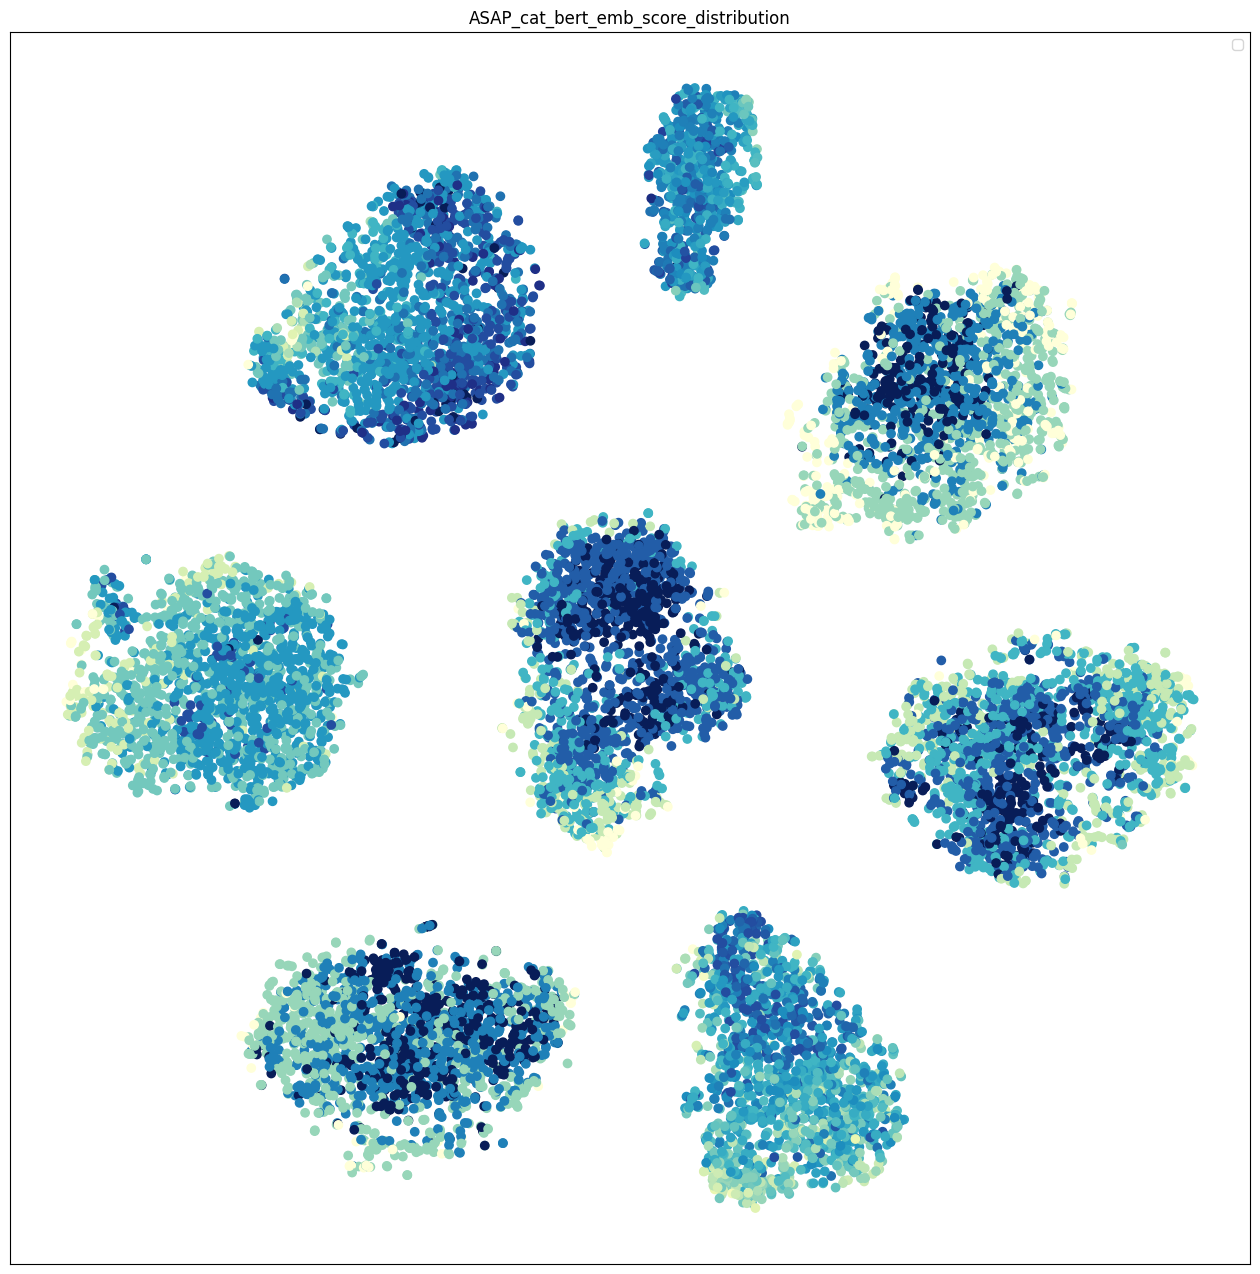

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12977 samples in 0.014s...
[t-SNE] Computed neighbors for 12977 samples in 1.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12977
[t-SNE] Computed conditional probabilities for sample 2000 / 12977
[t-SNE] Computed conditional probabilities for sample 3000 / 12977
[t-SNE] Computed conditional probabilities for sample 4000 / 12977
[t-SNE] Computed conditional probabilities for sample 5000 / 12977
[t-SNE] Computed conditional probabilities for sample 6000 / 12977
[t-SNE] Computed conditional probabilities for sample 7000 / 12977
[t-SNE] Computed conditional probabilities for sample 8000 / 12977
[t-SNE] Computed conditional probabilities for sample 9000 / 12977
[t-SNE] Computed conditional probabilities for sample 10000 / 12977
[t-SNE] Computed conditional probabilities for sample 11000 / 12977
[t-SNE] Computed conditional probabilities for sample 12000 / 12977
[t-SNE] Computed conditional probabilities for sam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


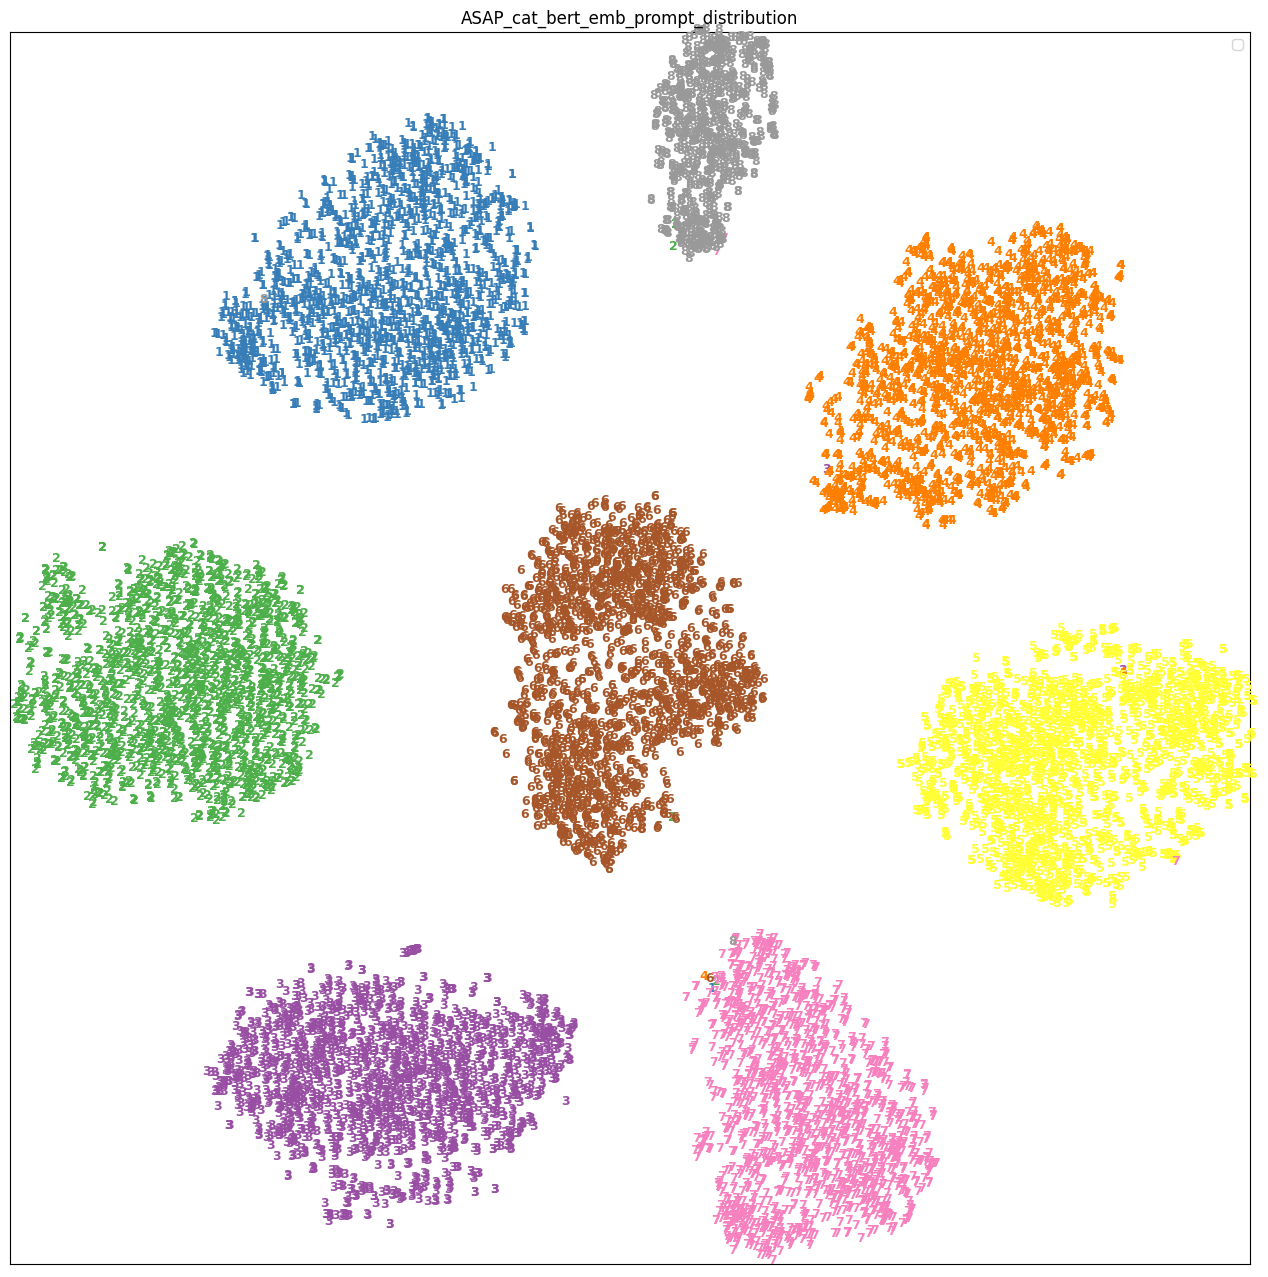

In [40]:
plot_feature(result1,'emb','score','bert')
plot_feature(result1,'emb','prompt','bert')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12977 samples in 0.006s...
[t-SNE] Computed neighbors for 12977 samples in 0.761s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12977
[t-SNE] Computed conditional probabilities for sample 2000 / 12977
[t-SNE] Computed conditional probabilities for sample 3000 / 12977
[t-SNE] Computed conditional probabilities for sample 4000 / 12977
[t-SNE] Computed conditional probabilities for sample 5000 / 12977
[t-SNE] Computed conditional probabilities for sample 6000 / 12977
[t-SNE] Computed conditional probabilities for sample 7000 / 12977
[t-SNE] Computed conditional probabilities for sample 8000 / 12977
[t-SNE] Computed conditional probabilities for sample 9000 / 12977
[t-SNE] Computed conditional probabilities for sample 10000 / 12977
[t-SNE] Computed conditional probabilities for sample 11000 / 12977
[t-SNE] Computed conditional probabilities for sample 12000 / 12977
[t-SNE] Computed conditional probabilities for sam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


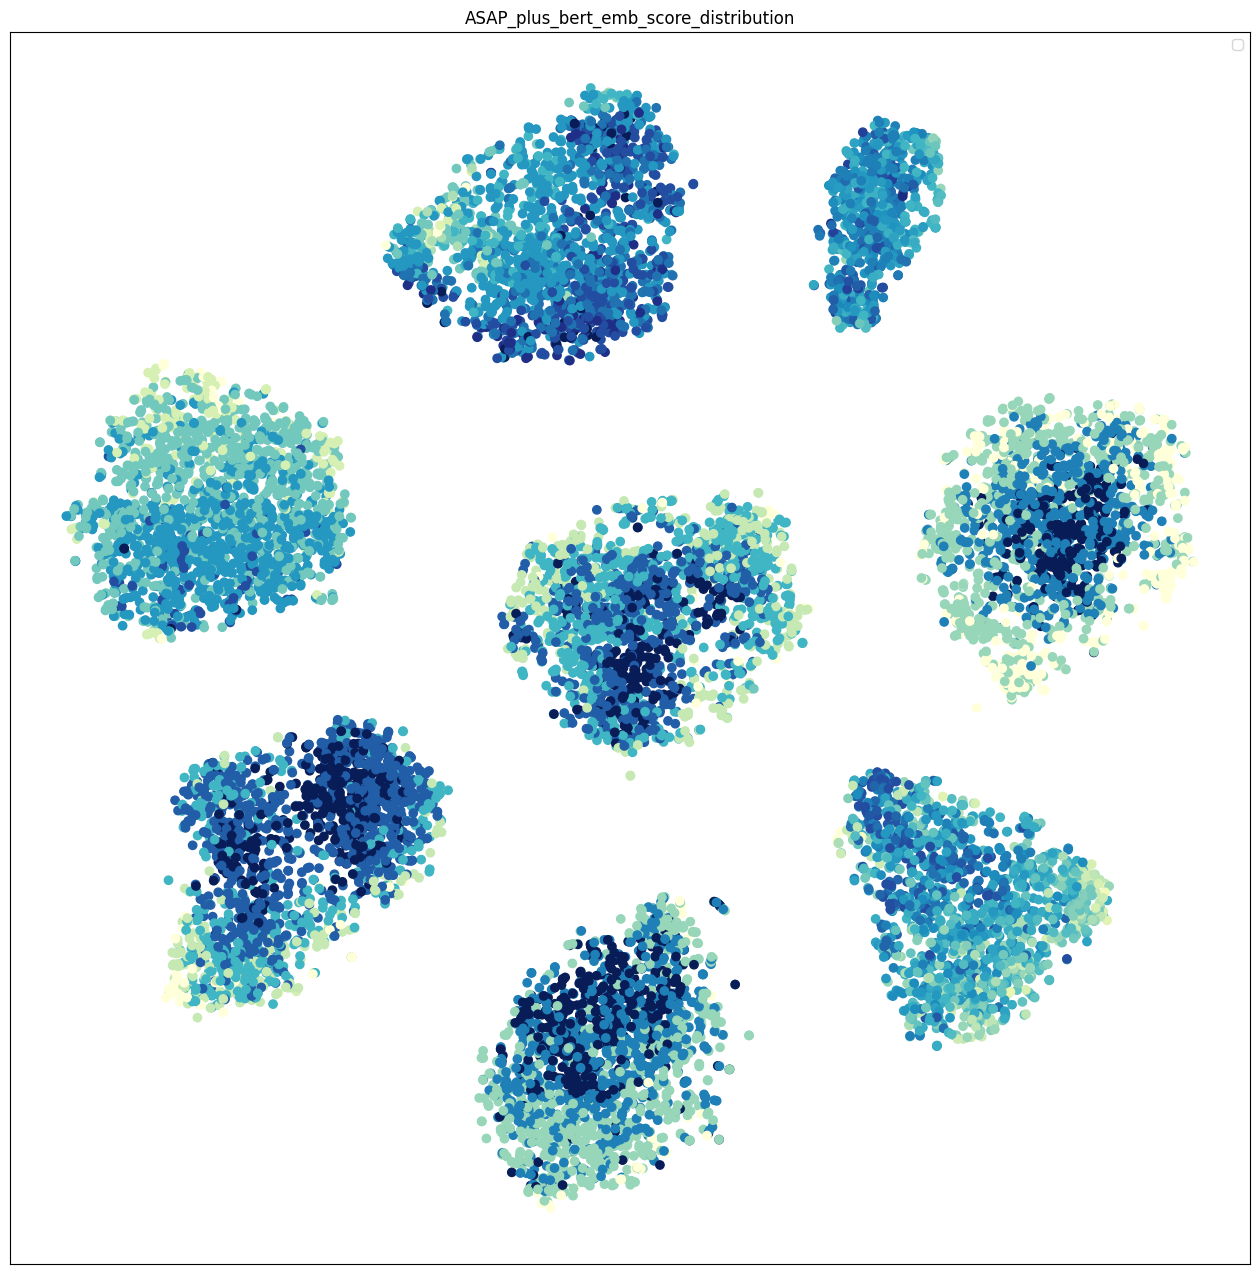

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12977 samples in 0.011s...
[t-SNE] Computed neighbors for 12977 samples in 0.757s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12977
[t-SNE] Computed conditional probabilities for sample 2000 / 12977
[t-SNE] Computed conditional probabilities for sample 3000 / 12977
[t-SNE] Computed conditional probabilities for sample 4000 / 12977
[t-SNE] Computed conditional probabilities for sample 5000 / 12977
[t-SNE] Computed conditional probabilities for sample 6000 / 12977
[t-SNE] Computed conditional probabilities for sample 7000 / 12977
[t-SNE] Computed conditional probabilities for sample 8000 / 12977
[t-SNE] Computed conditional probabilities for sample 9000 / 12977
[t-SNE] Computed conditional probabilities for sample 10000 / 12977
[t-SNE] Computed conditional probabilities for sample 11000 / 12977
[t-SNE] Computed conditional probabilities for sample 12000 / 12977
[t-SNE] Computed conditional probabilities for sam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


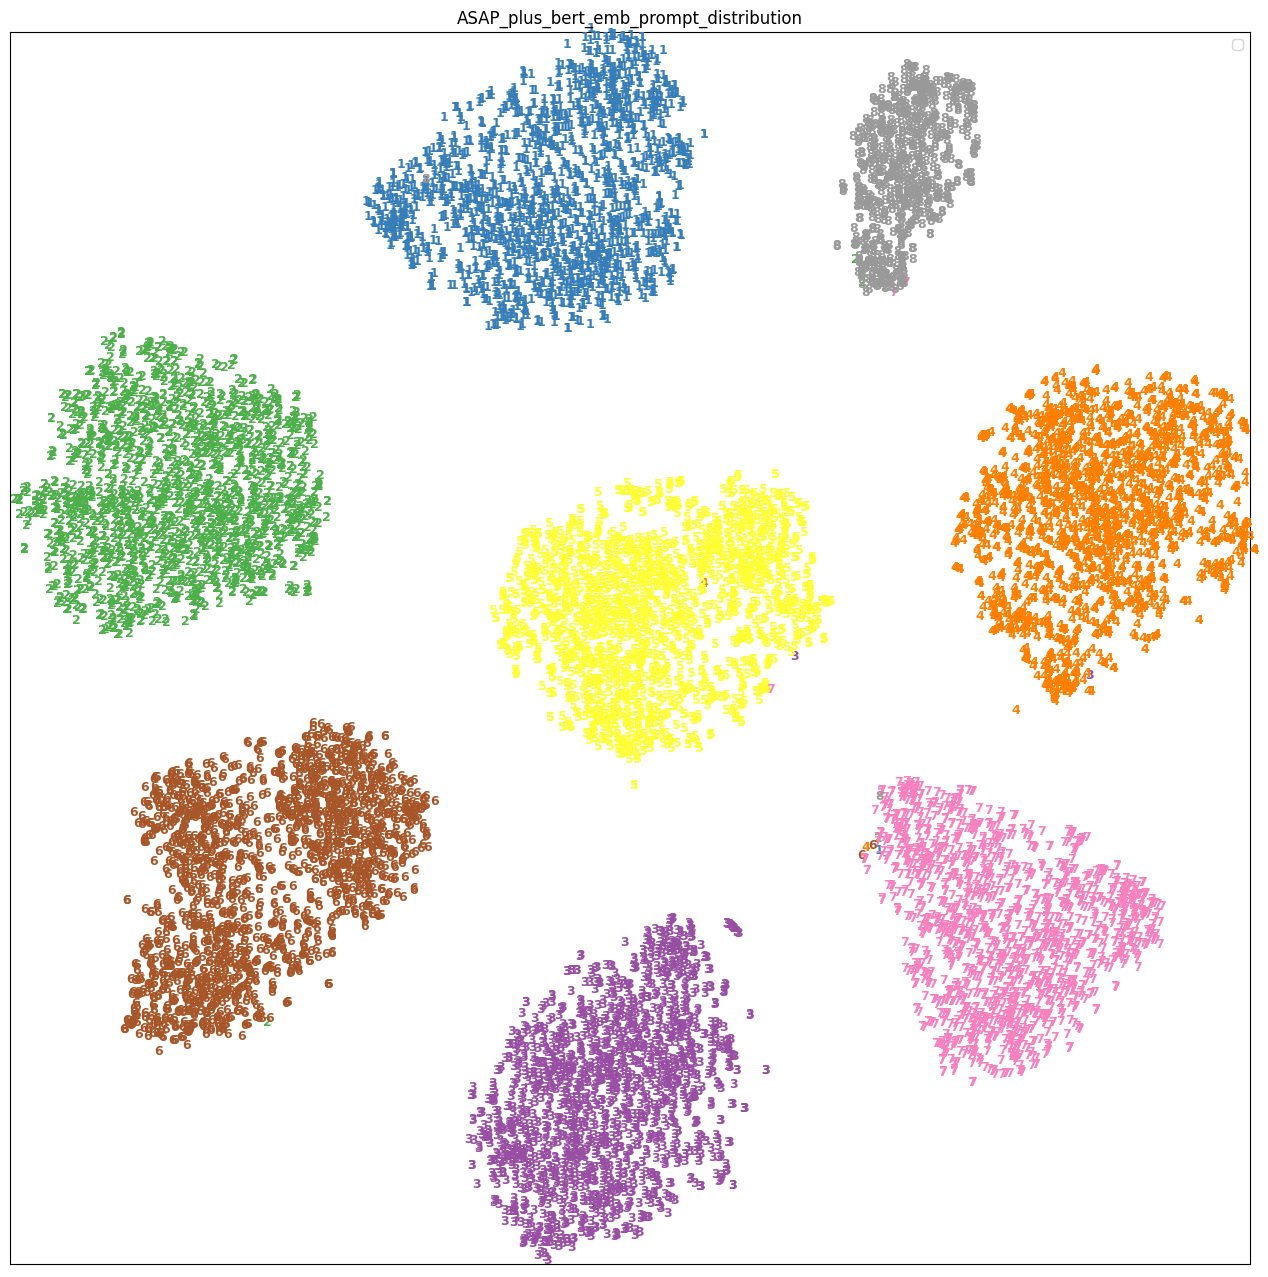

In [38]:
plot_feature(result2,'emb','score','bert')
plot_feature(result2,'emb','prompt','bert')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12977 samples in 0.005s...
[t-SNE] Computed neighbors for 12977 samples in 0.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12977
[t-SNE] Computed conditional probabilities for sample 2000 / 12977
[t-SNE] Computed conditional probabilities for sample 3000 / 12977
[t-SNE] Computed conditional probabilities for sample 4000 / 12977
[t-SNE] Computed conditional probabilities for sample 5000 / 12977
[t-SNE] Computed conditional probabilities for sample 6000 / 12977
[t-SNE] Computed conditional probabilities for sample 7000 / 12977
[t-SNE] Computed conditional probabilities for sample 8000 / 12977
[t-SNE] Computed conditional probabilities for sample 9000 / 12977
[t-SNE] Computed conditional probabilities for sample 10000 / 12977
[t-SNE] Computed conditional probabilities for sample 11000 / 12977
[t-SNE] Computed conditional probabilities for sample 12000 / 12977
[t-SNE] Computed conditional probabilities for sam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


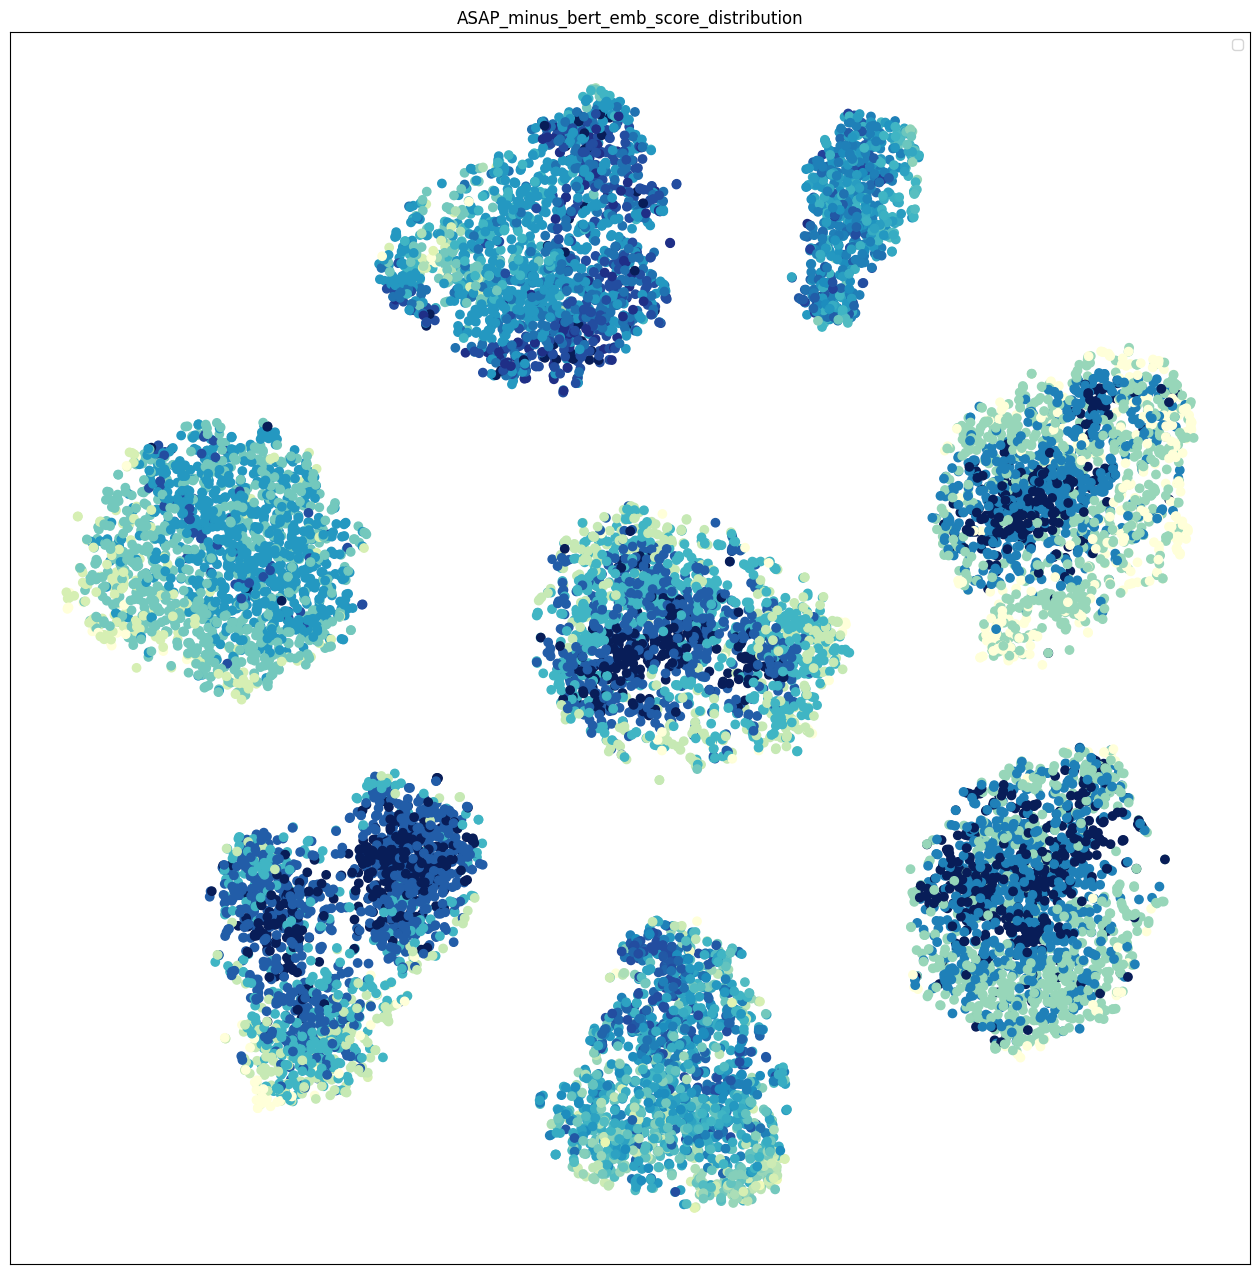

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12977 samples in 0.013s...
[t-SNE] Computed neighbors for 12977 samples in 0.749s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12977
[t-SNE] Computed conditional probabilities for sample 2000 / 12977
[t-SNE] Computed conditional probabilities for sample 3000 / 12977
[t-SNE] Computed conditional probabilities for sample 4000 / 12977
[t-SNE] Computed conditional probabilities for sample 5000 / 12977
[t-SNE] Computed conditional probabilities for sample 6000 / 12977
[t-SNE] Computed conditional probabilities for sample 7000 / 12977
[t-SNE] Computed conditional probabilities for sample 8000 / 12977
[t-SNE] Computed conditional probabilities for sample 9000 / 12977
[t-SNE] Computed conditional probabilities for sample 10000 / 12977
[t-SNE] Computed conditional probabilities for sample 11000 / 12977
[t-SNE] Computed conditional probabilities for sample 12000 / 12977
[t-SNE] Computed conditional probabilities for sam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


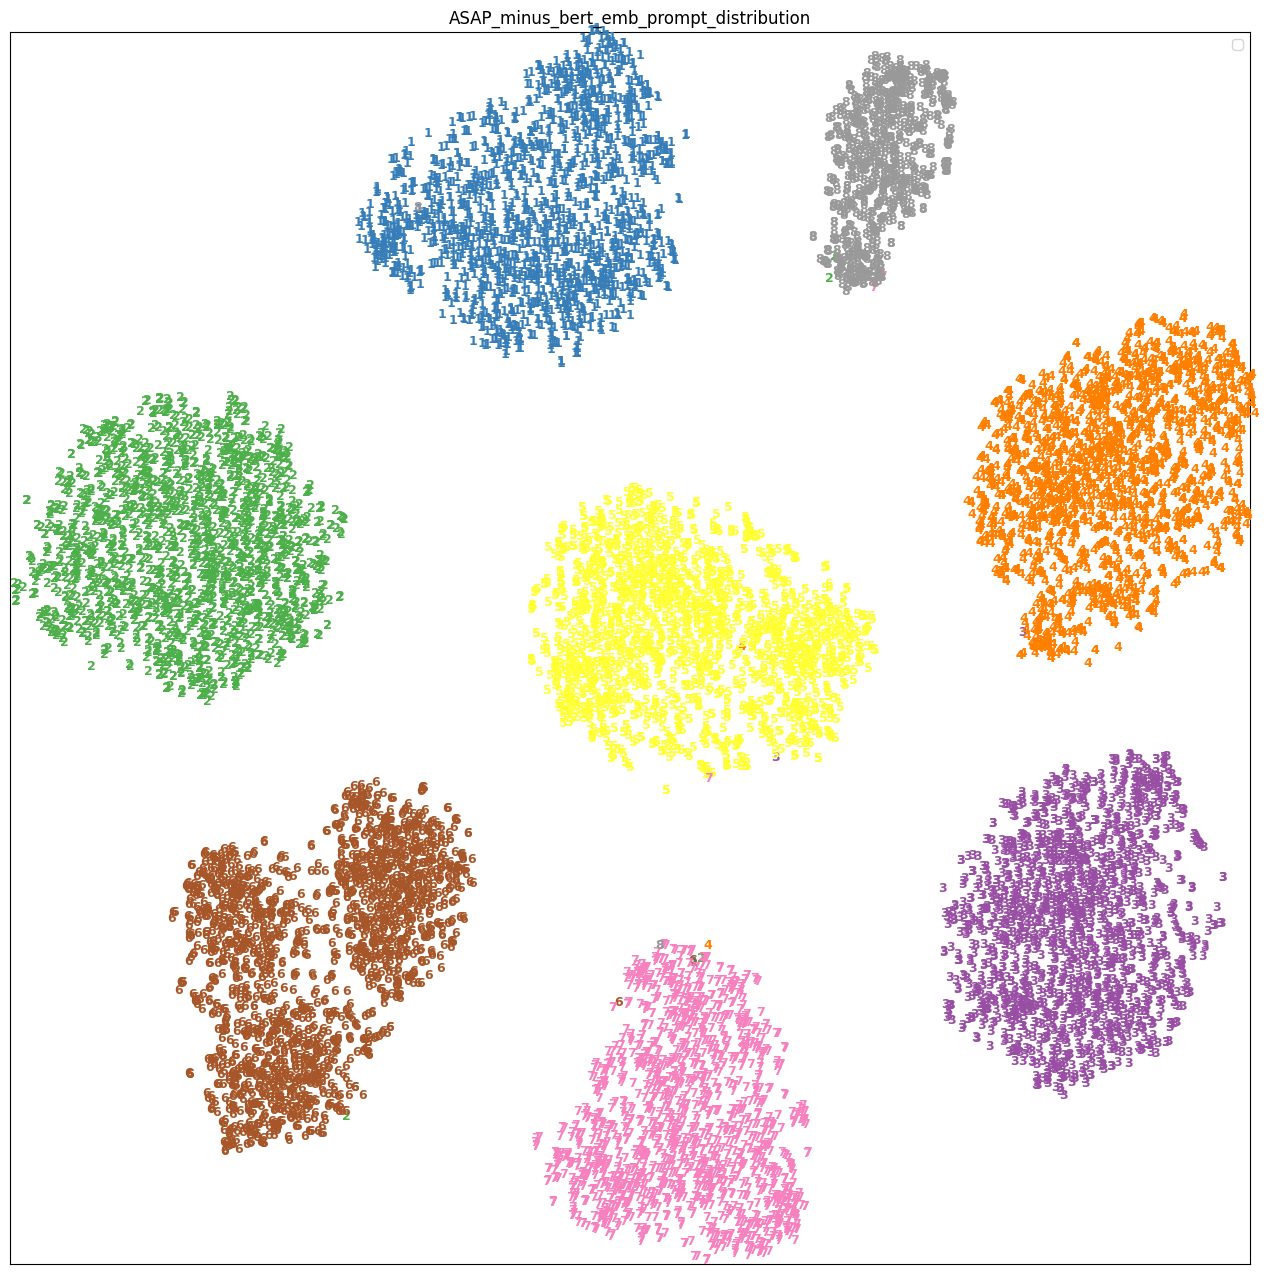

In [46]:
plot_feature(result3,'emb','score','bert')
plot_feature(result3,'emb','prompt','bert')